# Calculate sigmav vs. mDM for simulated DM datasets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from gammapy.astro.darkmatter.utils import SigmaVEstimator
from gammapy.spectrum import SpectrumDatasetOnOff, CountsSpectrum
from gammapy.astro.darkmatter import DMAnnihilation
from gammapy.irf import load_cta_irfs

## Define parameters for simulated observation

In [2]:
# -
livetime = 100 * u.h # in hours
offset = 0.5 * u.deg
GLON=0 * u.deg  # -> convert to ALtAz
GLAT=0 * u.deg  # -> convert to ALtAz

# Energy from 0.01 to 100 TeV with 20 bins/decade
energy = np.logspace(-1.8, 1.5, 20) * u.TeV

# Energy true wider range and higher number of bins
energy_true = np.logspace(-2, 2, 100) * u.TeV

# DMAnnihilation Model
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 5

## Build IRFs with the defined parameters

In [3]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

NDDataArray summary info
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



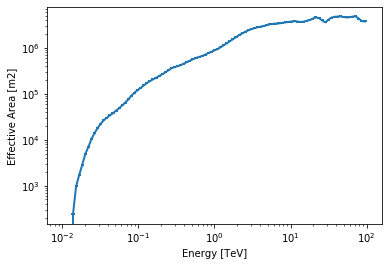

In [4]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy_true)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

NDDataArray summary info
MapAxis

	name       : e_true    
	unit       : 'TeV'     
	nbins      : 99        
	node type  : edges     
	edges min  : 1.0e-02 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       
MapAxis

	name       : e_reco    
	unit       : 'TeV'     
	nbins      : 19        
	node type  : edges     
	edges min  : 1.6e-02 TeV
	edges max  : 3.2e+01 TeV
	interp     : log       
Data           : size =  1881, min =  0.000, max =  0.997



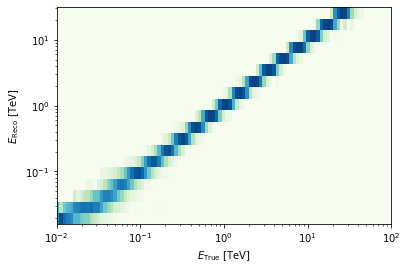

In [5]:
edisp = cta_irf["edisp"].to_energy_dispersion(
    offset=offset, e_true=energy_true, e_reco=energy
)
edisp.plot_matrix()
print(edisp.data)

## Build the background counts from PSF and IRF background

In [6]:
containment = 0.68
energies = np.sqrt(energy[1:] * energy[:-1])
psf = cta_irf["psf"].to_energy_dependent_table_psf(theta=offset)
on_radii = psf.containment_radius(energy=energies, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

#
aeff.data.data *= containment

In [7]:
bkg_data = cta_irf["bkg"].evaluate_integrate(
    fov_lon=GLON, fov_lat=GLAT, energy_reco=energy
)
bkg = CountsSpectrum(
    energy[:-1],
    energy[1:],
    data=(bkg_data * solid_angles).to_value("h-1")*livetime
)

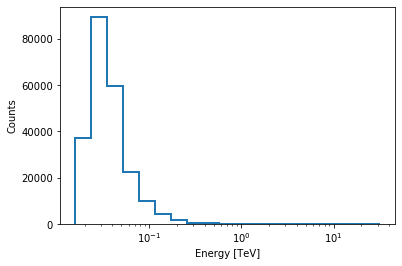

In [8]:
bkg.plot_hist()

## Simulate OnOff observation with DM emission model

In [9]:
# DM Flux
flux_model = DMAnnihilation(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

In [10]:
dataset = SpectrumDatasetOnOff(
    aeff=aeff,
    edisp=edisp,
    model=flux_model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
# dataset.fake(background_model=bkg) #simulation

## Estimate sigma v

**Enable inspection**

In [11]:
import logging
logging.basicConfig()
logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("ERROR")
#logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("ERROR")

**Instatiate estimator**

In [12]:
masses = [100, 200, 500, 1000, 5000, 10000, 50000]*u.GeV
channels = ["b", "tau", "Z", "W"] 
estimator = SigmaVEstimator(dataset, masses, channels, jfact=JFAC, background_model=bkg)

**Run estimator and fetch results**

In [13]:
%%time
#likelihood_profile_opts=dict(bounds=50, nvalues=50),
result = estimator.run(30)

ERROR:gammapy.astro.darkmatter.utils:Channel: tau - Run: 0 - Mass: 5000.0 GeV
ERROR:gammapy.astro.darkmatter.utils:Flat likelihood
ERROR:gammapy.astro.darkmatter.utils:Channel: tau - Run: 0 - Mass: 50000.0 GeV
ERROR:gammapy.astro.darkmatter.utils:Flat likelihood
ERROR:gammapy.astro.darkmatter.utils:Channel: W - Run: 0 - Mass: 10000.0 GeV
ERROR:gammapy.astro.darkmatter.utils:Flat likelihood
ERROR:gammapy.astro.darkmatter.utils:Channel: W - Run: 0 - Mass: 50000.0 GeV
ERROR:gammapy.astro.darkmatter.utils:Flat likelihood
ERROR:gammapy.astro.darkmatter.utils:Channel: W - Run: 4 - Mass: 10000.0 GeV
ERROR:gammapy.astro.darkmatter.utils:Flat likelihood
ERROR:gammapy.astro.darkmatter.utils:Channel: tau - Run: 7 - Mass: 50000.0 GeV
ERROR:gammapy.astro.darkmatter.utils:Flat likelihood
ERROR:gammapy.astro.darkmatter.utils:Channel: tau - Run: 8 - Mass: 50000.0 GeV
ERROR:gammapy.astro.darkmatter.utils:Flat likelihood
ERROR:gammapy.astro.darkmatter.utils:Channel: tau - Run: 15 - Mass: 50000.0 GeV
ERR

CPU times: user 2min 37s, sys: 5.06 s, total: 2min 42s
Wall time: 2min 56s


## Inspection of results

**Display results for channel b and second run**

In [19]:
cols = ["mass", "sigma_v", "scale_best", "scale_ul", "likeprofile"]
result["runs"]["b"][0][cols]

mass,sigma_v,scale_best,scale_ul,likeprofile
GeV,cm3 / s,,,
float64,float64,float64,float64,object
100.0,1.0641438913301339e-24,0.0,35.471463044337796,"{'values': array([0.00000000e+00, 1.31012472e-01, 6.26776638e+00, 1.24045203e+01, 1.85412742e+01, 2.46780281e+01, 3.08147820e+01, 3.69515359e+01, 4.30882899e+01, 4.92250438e+01, 5.53617977e+01, 6.14985516e+01, 6.76353055e+01, 7.37720594e+01, 7.99088133e+01, 8.60455672e+01, 9.21823212e+01, 9.83190751e+01, 1.04455829e+02, 1.10592583e+02, 1.16729337e+02, 1.22866091e+02, 1.29002845e+02, 1.35139599e+02]), 'likelihood': array([13.05172047, 13.0563855 , 13.32881002, 13.68428 , 14.12271099, 14.64401878, 15.24811942, 15.93492916, 16.70436452, 17.55634224, 18.49077931, 19.50759293, 20.60670056, 21.78801989, 23.05146883, 24.39696553, 25.82442838, 27.33377599, 28.92492721, 30.59780112, 32.352317 , 34.1883944 , 36.10595308, 38.10491301])}"
200.0,5.7492783817055e-25,0.0,19.164261272351666,"{'values': array([ 0. , 2.74504134, 6.18502636, 9.62501138, 13.0649964 , 16.50498142, 19.94496643, 23.38495145, 26.82493647, 30.26492149, 33.70490651, 37.14489153, 40.58487654, 44.02486156, 47.46484658, 50.9048316 , 54.34481662, 57.78480163, 61.22478665, 64.66477167, 68.10475669, 71.54474171, 74.98472673]), 'likelihood': array([13.05460909, 13.28226408, 13.64607223, 14.09278336, 14.62232193, 15.23461258, 15.92958015, 16.70714965, 17.56724631, 18.5097955 , 19.53472282, 20.64195402, 21.83141507, 23.10303209, 24.4567314 , 25.89243951, 27.4100831 , 29.00958903, 30.69088435, 32.45389629, 34.29855225, 36.22477982, 38.23250675])}"
500.0,3.50296616502037e-25,0.0,11.676553883401233,"{'values': array([ 0. , 2.23336621, 4.50445382, 6.77554144, 9.04662905, 11.31771667, 13.58880428, 15.8598919 , 18.13097951, 20.40206713, 22.67315474, 24.94424236, 27.21532997, 29.48641759, 31.7575052 , 34.02859282, 36.29968043, 38.57076805, 40.84185566, 43.11294328, 45.38403089, 47.65511851]), 'likelihood': array([13.05166252, 13.40086687, 13.83824032, 14.3582737 , 14.96085822, 15.64588529, 16.41324651, 17.26283366, 18.19453874, 19.20825393, 20.30387159, 21.48128428, 22.74038477, 24.08106598, 25.50322107, 27.00674335, 28.59152636, 30.25746381, 32.00444959, 33.8323778 , 35.74114273, 37.73063886])}"
1000.0,3.1119942194377835e-25,0.0,10.373314064792611,"{'values': array([ 0. , 1.49938267, 3.40414515, 5.30890762, 7.2136701 , 9.11843257, 11.02319505, 12.92795752, 14.83272 , 16.73748247, 18.64224495, 20.54700742, 22.4517699 , 24.35653237, 26.26129485, 28.16605732, 30.0708198 , 31.97558227, 33.88034475, 35.78510722, 37.6898697 , 39.59463217, 41.49939465]), 'likelihood': array([13.05660605, 13.29272181, 13.67306659, 14.13592221, 14.68111633, 15.30847706, 16.01783297, 16.80901307, 17.68184684, 18.63616419, 19.67179549, 20.78857157, 21.9863237 , 23.26488359, 24.62408342, 26.0637558 , 27.5837338 , 29.18385094, 30.86394117, 32.6238389 , 34.46337898, 36.3823967 , 38.38072781])}"
5000.0,5.308798586090812e-25,1.3770942987189434,17.695995286969374,"{'values': array([-47.65943784, -45.65794673, -43.65645562, -41.65496452, -39.65347341, -37.6519823 , -35.65049119, -33.64900008, -31.64750898, -29.64601787, -27.64452676, -25.64303565, -23.64154455, -21.64005344, -19.63856233, -17.63707122, -15.63558012, -13.63408901, -11.6325979 , -9.63110679, -7.62961569, -5.62812458, -3.62663347, -1.62514236, 0.37634874, 2.37783985, 4.37933096, 6.38082207, 8.38231318, 10.38380428, 12.38529539, 14.3867865 , 16.38827761, 18.38976871, 20.39125982, 22.39275093, 24.39424204, 26.39573314, 28.39722425, 30.39871536, 32.40020647, 34.40169757, 36.40318868, 38.40467979, 40.4061709 , 42.407662 , 44.40915311, 46.41064422, 48.41213533, 50.41362644]), 'likelihood': array([39.9305742 , 37.72155862, 35.61274482, 33.60334895, 31.69259207, 29.87970027, 28.16390486, 26.54444241, 25.02055496, 23.59149004, 22.2565008 , 21.01484614, 19.8657907 , 18.80860503, 17.8425656 , 16.96695488, 16.18106138, 15.48417971, 14.87561064, 14.35466108, 13.92064415, 13.57287922, 13.31069189, 13.13341401, 13.0421

**Plot likelihood profile for a specific fit**

In [20]:
mask = result["runs"]["b"][0]["mass"] == 1000.0
profile = result["runs"]["b"][0]["likeprofile"][mask][0]

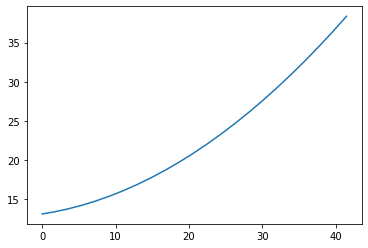

In [21]:
plt.plot(profile["values"], profile["likelihood"]);

## Plot obtained results for sigma

In [22]:
result["mean"]["W"]

mass,sigma_v,std
GeV,cm3 / s,cm3 / s
float64,float64,float64
100.0,1.6504740675712623e-24,7.977674796863447e-25
200.0,6.629047315341281e-25,2.9716583691951943e-25
500.0,3.7631071241523197e-25,1.5632270961283334e-25
1000.0,3.1453656544250433e-25,1.3803630936817445e-25
5000.0,2.8857878201678814e-25,1.4443952365202313e-25
10000.0,1.9073147535214242e-25,1.2026525066481416e-25
50000.0,1.2390568208926669e-24,7.4098975272644575e-25


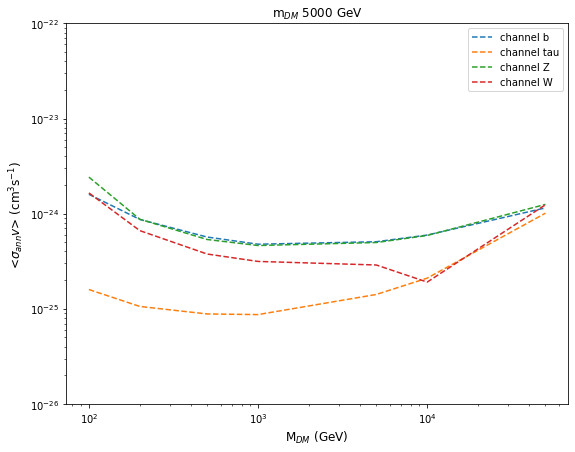

In [23]:
plt.figure(figsize=(9,7))
plt.ylim(1e-26, 1e-22)
plt.ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
plt.xlabel("M$_{DM}$ (GeV)", fontsize=12)
plt.title('m$_{DM}$ 5000 GeV')

for ch in channels:
    plt.loglog(
        result["mean"][ch]["mass"].data,
        result["mean"][ch]["sigma_v"].data,
        ls="--",
        label='channel {}'.format(ch)
       )
plt.legend();